# Tutorial : ElegantRun - Tracking

In [9]:
import pandas as pd
import numpy as np

from pyelegantsdds.elegantrun import ElegantRun
from pyelegantsdds.sdds import SDDS

from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# path to singularity container with parallel elegant installed
sif = "/home/mti/gitlab-hzb/containers/bin/pelegant.sif"

## Lattices

In [4]:
# lattice element definitions
elements ={
    "QF": {"type" : "KQUAD", "L": 0.342, "K1":  0.4900, "N_KICKS": 16},
    "QD": {"type" : "KQUAD", "L": 0.668, "K1": -0.4999, "N_KICKS": 16},
    "D":  {"type" : "DRIF" , "L": 3.5805},
    "W1": {"type" : "WATCH", "filename":"\"%s-%03ld.w1\"","mode": "coordinates"}
}

FODOstr = "! FODO cell.\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line     = ["W1","QF","D","QD","D","QF"]
linestr  = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

print(FODOstr)

with open("FODO.lte","w") as f:
    f.write(FODOstr)

! FODO cell.

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


In [5]:
# Lattice parTrack from Elegant examples
latstr = """
l1a: DRIF, L=0.2
l1b: DRIF, L=1.531675
lqb: DRIF, L=0.24
l2:  DRIF, L=0.08
l3:  DRIF, L=1.47
l3a: DRIF, L=0.568095770758662
l3b: DRIF, L=0.551904229241338

! LHK is half the effective length of a kicker
lhk:  DRIF, L=0.175
l34a: DRIF, L=0.811087
l34b: DRIF, L=0.308913

l4: DRIF, L=0.08
l5: DRIF, L=0.325

b1: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1
b2: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1

q1: KQUAD, L=0.23, k1=1.786022448154, n_kicks=10
q2: KQUAD, L=0.23, k1=2.295915530046, n_kicks=10
q3: KQUAD, l=0.23, k1=0.0
q4: KQUAD, l=0.23, k1=2.270174600496, n_kicks=10

s1h: SEXT, l=0.1, k2=0.0

! vertical chromaticity sextupole plus vertical steering magnet
sdh: KSEXT, l=0.1, k2=5.95873739969822, n_kicks=4

! horizontal chromaticity sextupole plus horizontal steering magnet
sfh: ksextupole, l=0.1, k2=-1.65546424863732, n_kicks=4

s1: line=(s1h,s1h)
sd: line=(sdh,sdh)
sf: line=(sfh,sfh)

! markers for the septum center and the center of the RF straight
msept: marker
mrf:   marker

! quadrant 1, less half of SF
quadr1: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 2, less half of SF
quadr2: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 3, less half of SF
quadr3: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 4, less half of SF
quadr4: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l34a,lhk,lhk,l34b,sd,l4,q3,lqb,b2,lqb,q4,l5)

half: line=(quadr2,sf,-quadr2)

ap: rcol,x_max=0.04,y_max=0.01
par: line=(2*half,ap)
return

""".upper()

with open('parTrack.lte','w') as f:
    f.write(latstr)

## Tracking

### Sinlge particle simple

In [6]:
# set lattice for the rest of the tutorial
lattice = "FODO.lte"

# create instance of the class
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

# run tracking of single particle with given init coord.
er.simple_single_particle_track(n_passes=100, coord=np.array([1e-5,0,0,0,0]))

Shape: (1, 6) - Number of paritcles: 1 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [ ]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
#     file="temp-001.w1",
    graph="symb,vary=subtype,fill",
    device='png',
    output="FODO_single_particle.png"
)

![title](FODO_single_particle.png)

### Multi-particle Tracking

#### Hypercube

In [8]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=7
                                   )

Shape: (16807, 6) - Number of paritcles: 16807 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


Let us have a look at a 3D cut of the initial distribution.

Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


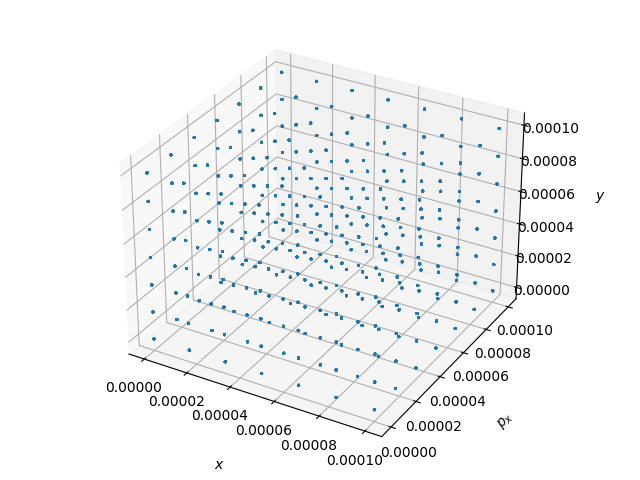

In [10]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df    = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.x,df.xp,df.y,s=1)

# labels
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')

# padding
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

plt.tight_layout()
plt.show()

In [11]:
# track
er.track_simple(n_passes=2**6)

In [13]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device='png',
    output="FODO_multi_particle_rectangular2.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=FODO_multi_particle_rectangular2.png


![title](FODO_multi_particle_rectangular2.png)

#### Higher dim ball

In [14]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
er.generate_sdds_particle_inputfile(grid_type='spherical',  
                                    dim=6,
                                    rmin=1e-6,
                                    rmax=1e-4,
                                    rsteps=5,
                                    phisteps=10,
                                    half=True, # False gives full spheres
                                    pcentralmev=er.kwargs.get('energy'),
                                   )

Shape: (5000, 6) - Number of paritcles: 5000 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


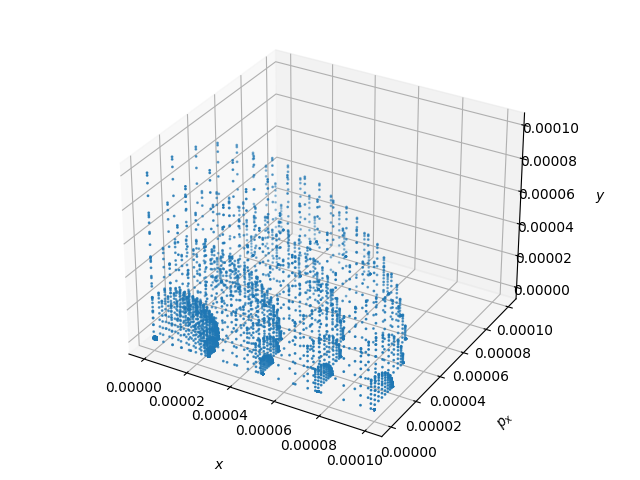

In [15]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.scatter(df.x,df.xp,df.y,s=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')
plt.tight_layout()
plt.show()

In [16]:
# track
er.track_simple(n_passes=2)

Warning - auto filename set
Changed from temp-001.w1 to temp-001.w1.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


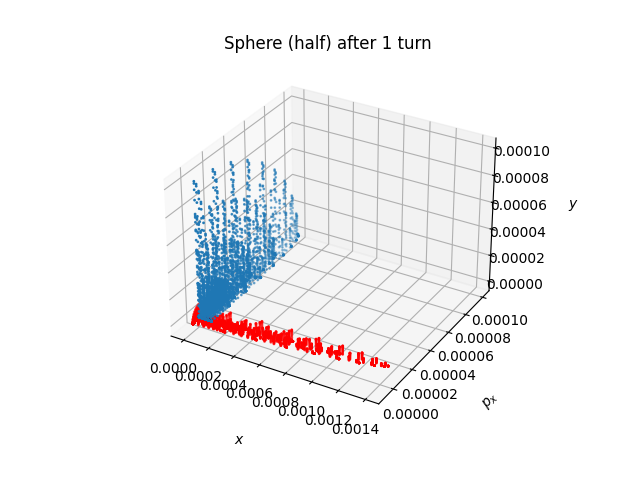

In [17]:
sddsp = SDDS(sif,"temp-001.w1",0)
df = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[df.Turn==1].x,df.loc[df.Turn==1].xp,df.loc[df.Turn==1].y,s=1)
ax.scatter(df.loc[df.Turn==2].x,df.loc[df.Turn==2].xp,df.loc[df.Turn==2].y,s=1,c='red')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')

plt.title('Sphere (half) after 1 turn')
plt.show()

#### Manual distribution

In [18]:
# load elegatnt similator
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

# twiss
twidata, twipar = er.findtwiss()
twipar.nux, twipar.nuy, twipar['dnux/dp'], twipar['dnuy/dp']

(0.2357264, 0.2343325, -0.0, -0.0)

In [22]:
# off - momentum
delta = 1.5e-3 * twipar.pCentral

# initial coordinate grid for tracking
man_ranges= {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05],
    2 : 0,
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

# generate coordinate input file
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=400)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [23]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

# uncomment to save to file
sddsp.sddsplot_base(
    columnNames="x,xp",
#     file="temp-001.w1",
    scale="-2.5,2.5,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="FODO_island.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -scale=-2.5,2.5,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=FODO_island.png


![title](FODO_island.png)

## Advanced Tracking

### FMA

In [24]:
lattice = 'parTrack.lte'
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)
er.fma(xmin=-0.05,xmax=0.05,ymin=0,ymax=0.02,nx=51,ny=51, n_passes=256)

In [35]:
sddsp = SDDS(sif,'temp.fma',0)
sddsp.sddsplot_fma(
#     file2="temp.fma",
    device='png',
    output="partrack_fma_diffusionrate.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp.fma -col=x,y -graph=sym,vary=subtype,fill,scale=2,fill -order=spectral -split=column=diffusionRate -device=png -output=partrack_fma_diffusionrate.png


![title](partrack_fma_diffusionrate.png)

In [ ]:
sddsp.sddsplot_tunediagram(scale="0,1,0,1", device='png',output="partrack_tune.png" )

![title](partrack_tune.png)

In [ ]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880)
# parallel only supports n-line
er.dynap(xmin=-0.1,xmax=0.1,ymin=0,ymax=0.1,nx=21,ny=21,n_lines=51)

In [ ]:
sddsp = SDDS(sif,"temp.aper",0)
sddsp.process_scan()

In [ ]:
sddsp.readParticleData()

In [ ]:
sddsp.sddsplot_base(col="x,y",file1=sddsp.filename, device='png',output="partrack_aper.png")

![title](partrack_aper.png)

In [ ]:
sddsp.addCommand('sddsplot', col='x,y', file=sddsp.filename,
                 graph="sym,vary=subtype",
                 order='spectral',split='column=sLost',
                )

In [ ]:
er.commandfile.addCommand('run_setup',lattice='parTrack.lte')

In [ ]:
sddsp.getColumnList()

In [ ]:
sddsp.getParameterList()

In [ ]:
sddsp.runCommand()

In [ ]:
sddsp.command_history

In [ ]:
 datasetdc = {
        "Q1" : [1.786022448154-0.01,1.786022448154+0.01],
        "Q2" : [2.295915530046-0.01,2.295915530046+0.01],
     
 }

er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )
er.track_vary(varydict=datasetdc,varyitemlist=['k1',"k1"],n_passes=2**4, add_watch_start=True, mode='row')

In [ ]:
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()

In [ ]:
data = sdds.readParticleData()
data


In [ ]:
sdds = SDDS(sif, "temp.sdds",0)

In [ ]:
sdds.getColumnValues()

In [ ]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
#     scale="-1e-4,1e-4,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
#     device='png',
#     output="FODO_multi_particle_rectangular2.png"
)

In [ ]:
import matplotlib.pyplot as plt

for i in [1.0*n for n in range(1,23)]:
    for name, group in data.loc[data.step==i].groupby("particleID"):
        plt.scatter(group["x"],group["xp"],s=1, label=name)
    #plt.xlim(-1,1)
    plt.show()